In [1]:
import os
import sys

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import json

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import torch
import torch.nn.functional as f
from gradslam.structures.pointclouds import Pointclouds
from PIL import Image

from core.dataset import ScanNet
from core.extractor import GroundedSAMInstanceExtractor, LSegFeatureExtractor, SAMMaskExtractor
from core.integrate import FeatureFusionScalableTSDFVolume
from core.labeler import CLIPTextQuerier, KMeansLabeler

In [3]:
device = "cuda:0"
sam_ckpt = "/home/quanta/Models/SAM/sam_vit_h_4b8939.pth"
sam_type = "vit_h"
clip_type = "ViT-B/32"  # this is the clip model used by clip-glass and DeCap
clip_download_root = "/home/quanta/.cache/clip"
lseg_ckpt = "/home/quanta/Models/LSeg/lseg_minimal_e200.ckpt"
grounding_dino_config_pth = "../../config/grounding_dino_config/GroundingDINO_SwinT_OGC.py"
grounding_dino_ckpt = "/home/quanta/Models/GroundingDINO/groundingdino_swint_ogc.pth"
ram_ckpt = "/home/quanta/Models/RAM_Tag2Text/ram_swin_large_14m.pth"
sam_hq_ckpt = "/home/quanta/Models/SAM_HQ/sam_hq_vit_h.pth"
mask_rcnn_ckpt = "/home/quanta/Models/scannet_mask_rcnn/model_0454999.pth"

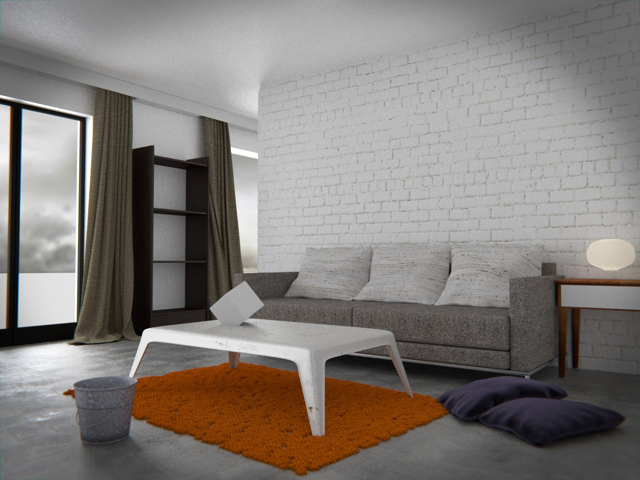

In [4]:
img = Image.open('../../examples/test-scene.jpg').resize((640, 480))
display(img)

In [5]:
extractor = LSegFeatureExtractor(lseg_ckpt=lseg_ckpt, device=device)
extractor.load_model()

In [6]:
sam_ext = GroundedSAMInstanceExtractor(
    ram_ckpt=ram_ckpt,
    grounding_dino_config_pth=grounding_dino_config_pth,
    grounding_dino_ckpt=grounding_dino_ckpt,
    sam_hq_ckpt=sam_hq_ckpt,
    device=device,
)
sam_ext.load_model()

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 30524. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


/encoder/layer/0/crossattention/self/query is tied
/encoder/layer/0/crossattention/self/key is tied
/encoder/layer/0/crossattention/self/value is tied
/encoder/layer/0/crossattention/output/dense is tied
/encoder/layer/0/crossattention/output/LayerNorm is tied
/encoder/layer/0/intermediate/dense is tied
/encoder/layer/0/output/dense is tied
/encoder/layer/0/output/LayerNorm is tied
/encoder/layer/1/crossattention/self/query is tied
/encoder/layer/1/crossattention/self/key is tied
/encoder/layer/1/crossattention/self/value is tied
/encoder/layer/1/crossattention/output/dense is tied
/encoder/layer/1/crossattention/output/LayerNorm is tied
/encoder/layer/1/intermediate/dense is tied
/encoder/layer/1/output/dense is tied
/encoder/layer/1/output/LayerNorm is tied
--------------
/home/quanta/Models/RAM_Tag2Text/ram_swin_large_14m.pth
--------------
load checkpoint from /home/quanta/Models/RAM_Tag2Text/ram_swin_large_14m.pth
vit: swin_l
final text_encoder_type: bert-base-uncased
<All keys ma

In [7]:
masks = sam_ext.get_masks(sam_ext.extract(img))

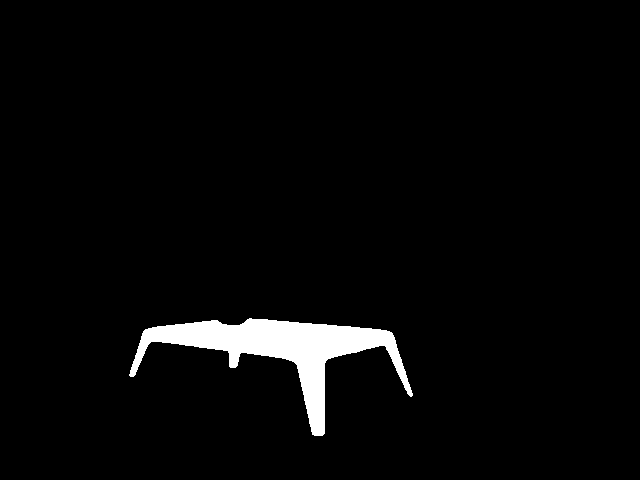

In [11]:
display(Image.fromarray(masks[4].cpu().numpy()).resize((640, 480)))

In [12]:
feats = extractor.get_feats(extractor.extract(img), output_height=480, output_width=640, normalize=False)

In [13]:
feats.shape

torch.Size([480, 640, 512])

In [14]:
temp = masks[4].argwhere()
mask_feat = f.normalize(feats[temp[:, 0], temp[:, 1]].mean(dim=0), dim=-1)
mask_feat.shape

torch.Size([512])

In [15]:
x, y = 520, 400
selected_feat = feats[y, x]

In [16]:
def show_points(coords, ax, marker_size=375):
    ax.scatter(coords[:, 0], coords[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

In [17]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([255 / 255, 255 / 255, 0 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

In [18]:
from core.captioner import ClipCapCaptioner, DeCapCaptioner

In [19]:
clipcap = ClipCapCaptioner(
    clipcap_ckpt="/home/quanta/Models/ClipCap/coco_weights.pt",
    device=device,
)
clipcap.load_model()
decap = DeCapCaptioner(
    decap_ckpt="/home/quanta/Models/decap/coco_prefix-009.pt",
    device=device,
)
decap.load_model()

In [20]:
mask_feat.norm(), selected_feat.norm()

(tensor(1., device='cuda:0'), tensor(1.4155, device='cuda:0'))

In [23]:
print(decap.get_caption(mask_feat, normalize=True))
print(decap.get_caption(mask_feat, normalize=False))

a table 
a table 


In [24]:
print(clipcap.get_caption(mask_feat, normalize=True))
print(clipcap.get_caption(mask_feat, normalize=False))

A picture of a roundabout with a person sitting on it.
A picture of a roundabout with a person sitting on it.


In [25]:
print(decap.get_caption(selected_feat, normalize=True))
print(decap.get_caption(selected_feat, normalize=False))

a blanket 
a blanket 


In [26]:
print(clipcap.get_caption(selected_feat, normalize=True))
print(clipcap.get_caption(selected_feat, normalize=False))

A picture of a street sign.
A picture of a street sign.


In [37]:
save_dir = '../03_caption/01_example/'
os.makedirs(save_dir, exist_ok=True)

<function matplotlib.pyplot.show(close=None, block=None)>

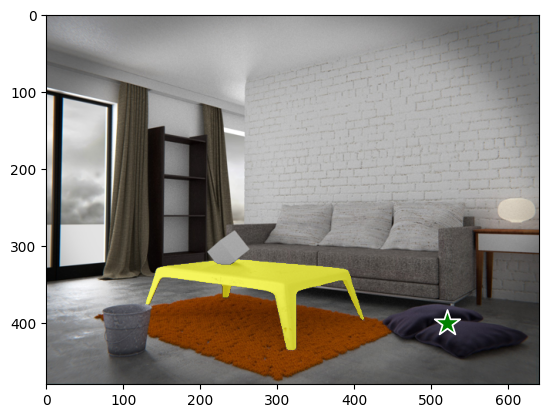

In [42]:
plt.imshow(img)
show_points(np.array([[x, y]]), plt.gca())
show_mask(mask=masks[3].cpu().numpy(), ax=plt.gca(), random_color=False)
plt.savefig(save_dir + 'example.pdf')
plt.show

# 02 resolution test (for concept fusion)

In [46]:
img_test = Image.open('../../examples/test-cup.jpg')

In [48]:
import clip

In [50]:
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
clip_model.eval().to(device);

In [52]:
save_dir = '../03_caption/02_resolution/'
os.makedirs(save_dir, exist_ok=True)

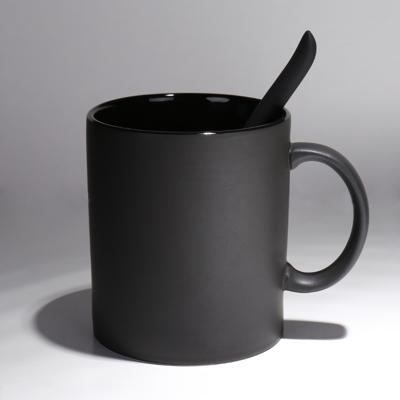

a coffee mug with dark colored condiments sits in the background 


In [66]:
res = 800
new_img = img_test.resize((res, res))
display(new_img.resize((400, 400)))
new_img.resize((400, 400)).save(save_dir + f"res_{res}.png")
img_feat = clip_model.encode_image(preprocess(new_img).unsqueeze(0).to(device)).float()
print(decap.get_caption(img_feat))

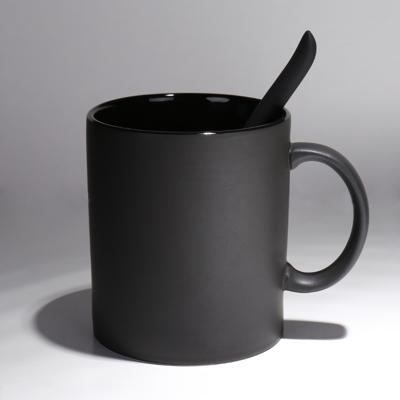

a coffee mug with dark colored coffee mug for sale 


In [67]:
res = 400
new_img = img_test.resize((res, res))
display(new_img.resize((400, 400)))
new_img.resize((400, 400)).save(save_dir + f"res_{res}.png")
img_feat = clip_model.encode_image(preprocess(new_img).unsqueeze(0).to(device)).float()
print(decap.get_caption(img_feat))

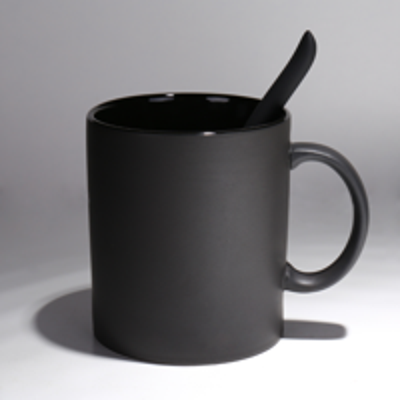

a black coffee mug with condiments in the background 


In [68]:
res = 200
new_img = img_test.resize((res, res))
display(new_img.resize((400, 400)))
new_img.resize((400, 400)).save(save_dir + f"res_{res}.png")
img_feat = clip_model.encode_image(preprocess(new_img).unsqueeze(0).to(device)).float()
print(decap.get_caption(img_feat))

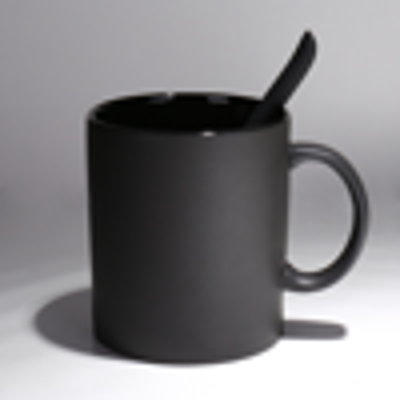

blurry photograph of coffee mug with coffee 


In [69]:
res = 100
new_img = img_test.resize((res, res))
display(new_img.resize((400, 400)))
new_img.resize((400, 400)).save(save_dir + f"res_{res}.png")
img_feat = clip_model.encode_image(preprocess(new_img).unsqueeze(0).to(device)).float()
print(decap.get_caption(img_feat))

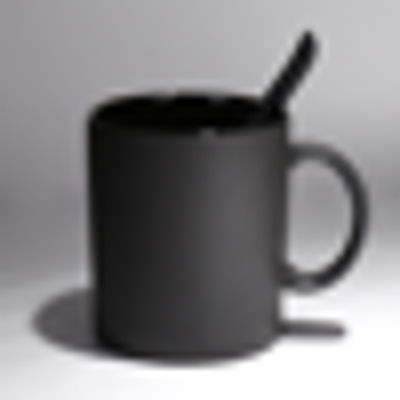

blurry photograph of coffee mug with a striped background 


In [70]:
res = 50
new_img = img_test.resize((res, res))
display(new_img.resize((400, 400)))
new_img.resize((400, 400)).save(save_dir + f"res_{res}.png")
img_feat = clip_model.encode_image(preprocess(new_img).unsqueeze(0).to(device)).float()
print(decap.get_caption(img_feat))

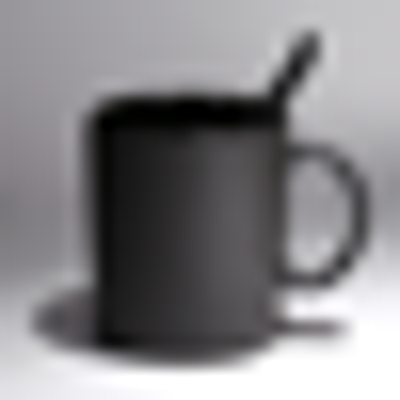

blurry image of coffee mug with striped word " 


In [71]:
res = 25
new_img = img_test.resize((res, res))
display(new_img.resize((400, 400)))
new_img.resize((400, 400)).save(save_dir + f"res_{res}.png")
img_feat = clip_model.encode_image(preprocess(new_img).unsqueeze(0).to(device)).float()
print(decap.get_caption(img_feat))

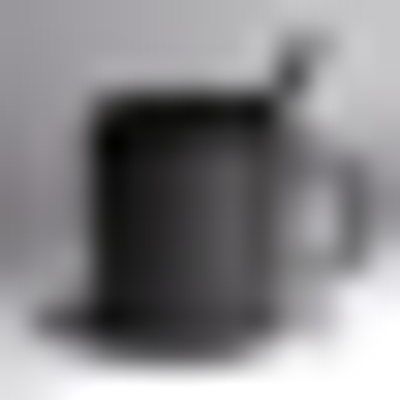

blurry image of coffee mug with a person in background 


In [72]:
res = 13
new_img = img_test.resize((res, res))
display(new_img.resize((400, 400)))
new_img.resize((400, 400)).save(save_dir + f"res_{res}.png")
img_feat = clip_model.encode_image(preprocess(new_img).unsqueeze(0).to(device)).float()
print(decap.get_caption(img_feat))

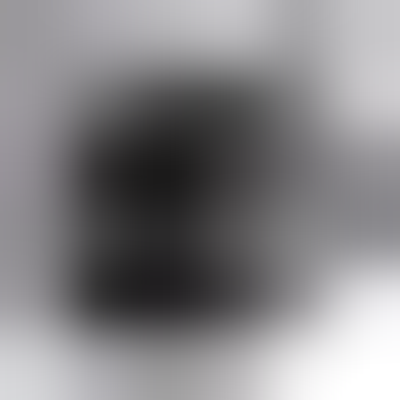

black photograph of cat with person 's eyes coming out of window 


In [73]:
res = 6
new_img = img_test.resize((res, res))
display(new_img.resize((400, 400)))
new_img.resize((400, 400)).save(save_dir + f"res_{res}.png")
img_feat = clip_model.encode_image(preprocess(new_img).unsqueeze(0).to(device)).float()
print(decap.get_caption(img_feat))